# Desafio de precificação de imóvel

O Objetivo desse notebook é criar um modelo de Machine Learning de precificação de imoveis baseado no conjunto de dados
disponibilizado pela empresa Keycash em seu Desafio de estágio de Ciencia de Dados de 2021

# Entendendo os dados do conjunto 

# Importando as bibliotecas necessarias

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from   sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import joblib



# Analise exploratoria dos dados do Dataset
Essa etapa consiste em verificar os detalhes dos dados e ver alguns parametros estatisticos entre as variaveis numericas do conjunto


In [2]:
data = pd.read_csv("./Desafio2_input.csv", sep=";")

data.head()

,Id,Zona,Area,Qualidade,AnoConstrucao,QualidadeAquecimento,Banheiros,Quartos_t1,Quartos_t2,Comodos,Lareiras,Garagem,Preco
0,1,RL,9600,6,1976,Ex,2,3,4,6,1,2,181500
1,2,RL,14115,5,1993,Ex,1,1,2,5,0,2,143000
2,3,RL,11200,5,1965,Ex,1,3,4,5,0,1,129500
3,4,RL,12968,5,1962,TA,1,2,3,4,0,1,144000
4,5,RL,10920,6,1960,TA,1,2,3,5,1,1,157000


In [3]:
#verifico os tipos de cada coluna e a quantidade de elementos nulos(caso exista)
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Id                    629 non-null    int64 
 1   Zona                  629 non-null    object
 2   Area                  629 non-null    int64 
 3   Qualidade             629 non-null    int64 
 4   AnoConstrucao         629 non-null    int64 
 5   QualidadeAquecimento  629 non-null    object
 6   Banheiros             629 non-null    int64 
 7   Quartos_t1            629 non-null    int64 
 8   Quartos_t2            629 non-null    int64 
 9   Comodos               629 non-null    int64 
 10  Lareiras              629 non-null    int64 
 11  Garagem               629 non-null    int64 
 12  Preco                 629 non-null    int64 
dtypes: int64(11), object(2)
memory usage: 64.0+ KB


Id                      0
Zona                    0
Area                    0
Qualidade               0
AnoConstrucao           0
QualidadeAquecimento    0
Banheiros               0
Quartos_t1              0
Quartos_t2              0
Comodos                 0
Lareiras                0
Garagem                 0
Preco                   0
dtype: int64

In [4]:
data.describe()

,Id,Area,Qualidade,AnoConstrucao,Banheiros,Quartos_t1,Quartos_t2,Comodos,Lareiras,Garagem,Preco
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,8932.025437,5.642289,1974.421304,1.370429,2.651828,3.651828,5.782194,0.515103,1.608903,148234.538951
std,181.72094,3318.885535,0.892748,19.189939,0.483304,0.551129,0.551129,1.039936,0.601361,0.577980,28088.037518
min,1.00000,1300.000000,4.000000,1940.000000,1.000000,1.000000,2.000000,3.000000,0.000000,0.000000,80000.000000
25%,158.00000,7420.000000,5.000000,1959.000000,1.000000,2.000000,3.000000,5.000000,0.000000,1.000000,129000.000000
50%,315.00000,9000.000000,6.000000,1971.000000,1.000000,3.000000,4.000000,6.000000,0.000000,2.000000,147000.000000
75%,472.00000,10530.000000,6.000000,1993.000000,2.000000,3.000000,4.000000,6.000000,1.000000,2.000000,173000.000000
max,629.00000,19900.000000,8.000000,2009.000000,2.000000,3.000000,4.000000,8.000000,2.000000,3.000000,200000.000000


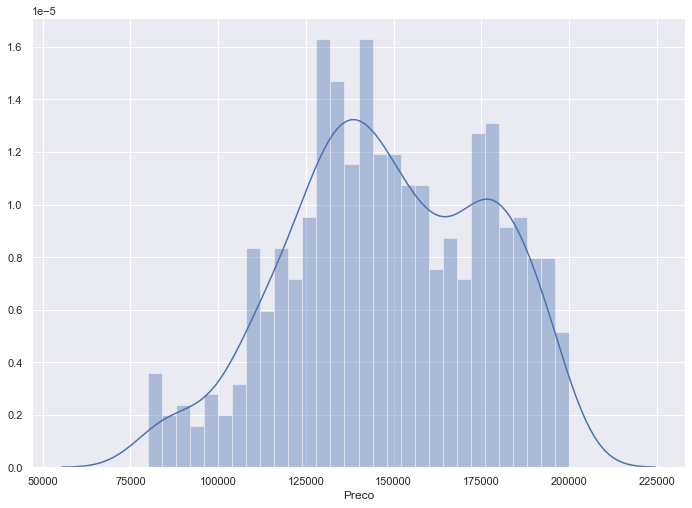

In [5]:
#visualizo a distribuição do preço
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(data['Preco'], bins=30)
plt.show()

# Feature engineering
Nessa etapa é tratado os dados para verificar quais possuem uma maior relação com a variavel preço, assim definindo as features do modelo

In [6]:
#separo as variaveis categoricas, aplicoo One-Hot-Encoding e concateno em um novo dataframe
array_categorical = ['Zona','QualidadeAquecimento']
categ_df = data[array_categorical]


categorical = pd.get_dummies(categ_df, prefix=['Zona','QualidadeAquecimento'])
df_OHS = pd.concat([data, categorical], axis=1)
df_OHS.head()

,Id,Zona,Area,Qualidade,AnoConstrucao,QualidadeAquecimento,Banheiros,Quartos_t1,Quartos_t2,Comodos,Lareiras,Garagem,Preco,Zona_RL,Zona_RM,QualidadeAquecimento_Ex,QualidadeAquecimento_Fa,QualidadeAquecimento_Gd,QualidadeAquecimento_TA
0,1,RL,9600,6,1976,Ex,2,3,4,6,1,2,181500,1,0,1,0,0,0
1,2,RL,14115,5,1993,Ex,1,1,2,5,0,2,143000,1,0,1,0,0,0
2,3,RL,11200,5,1965,Ex,1,3,4,5,0,1,129500,1,0,1,0,0,0
3,4,RL,12968,5,1962,TA,1,2,3,4,0,1,144000,1,0,0,0,0,1
4,5,RL,10920,6,1960,TA,1,2,3,5,1,1,157000,1,0,0,0,0,1


Ao aplicar o One-Hot-Encondig, verifico quais as features possuem uma maior correlação com a variavel preço

,Id,Area,Qualidade,AnoConstrucao,Banheiros,Quartos_t1,Quartos_t2,Comodos,Lareiras,Garagem,Preco,Zona_RL,Zona_RM,QualidadeAquecimento_Ex,QualidadeAquecimento_Fa,QualidadeAquecimento_Gd,QualidadeAquecimento_TA
Id,1.00,-0.05,0.04,0.03,0.03,-0.01,-0.01,0.05,-0.01,0.06,0.04,0.02,-0.02,0.03,0.04,0.02,-0.05
Area,-0.05,1.00,-0.03,-0.16,0.03,0.33,0.33,0.25,0.21,0.11,0.30,0.53,-0.53,-0.03,0.03,0.02,0.01
Qualidade,0.04,-0.03,1.00,0.58,0.59,0.07,0.07,0.39,0.26,0.46,0.66,0.07,-0.07,0.27,-0.04,-0.02,-0.24
AnoConstrucao,0.03,-0.16,0.58,1.00,0.61,-0.03,-0.03,0.20,-0.03,0.49,0.56,-0.04,0.04,0.39,-0.09,-0.06,-0.32
Banheiros,0.03,0.03,0.59,0.61,1.00,0.15,0.15,0.46,0.20,0.48,0.63,0.11,-0.11,0.25,-0.06,0.01,-0.24
Quartos_t1,-0.01,0.33,0.07,-0.03,0.15,1.00,1.00,0.56,0.10,0.03,0.19,0.34,-0.34,-0.11,0.05,0.00,0.10
Quartos_t2,-0.01,0.33,0.07,-0.03,0.15,1.00,1.00,0.56,0.10,0.03,0.19,0.34,-0.34,-0.11,0.05,0.00,0.10
Comodos,0.05,0.25,0.39,0.20,0.46,0.56,0.56,1.00,0.28,0.27,0.50,0.27,-0.27,0.09,0.04,0.04,-0.14
Lareiras,-0.01,0.21,0.26,-0.03,0.20,0.10,0.10,0.28,1.00,0.16,0.34,0.14,-0.14,-0.02,0.02,0.04,-0.01
Garagem,0.06,0.11,0.46,0.49,0.48,0.03,0.03,0.27,0.16,1.00,0.60,0.10,-0.10,0.18,-0.05,-0.00,-0.16


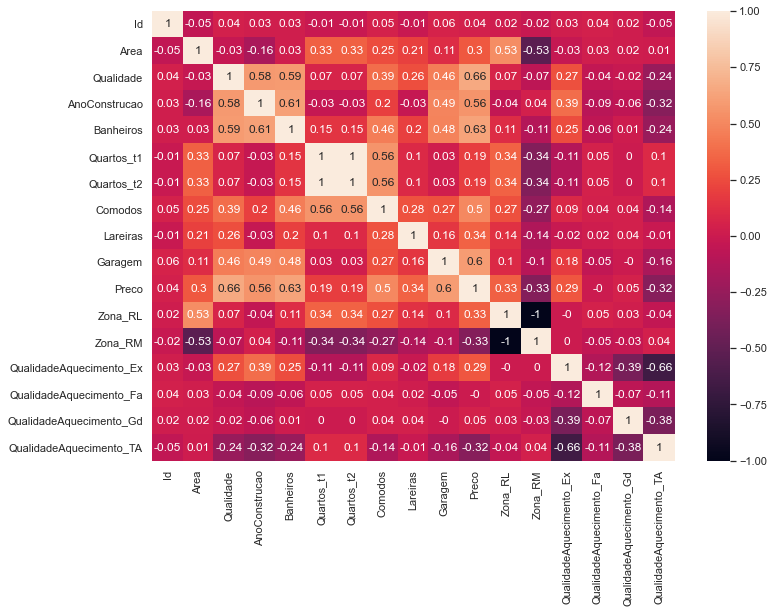

In [7]:
#mapa de calor com os dados da matriz correlacional
correlation_matrix = df_OHS.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)
df_OHS.corr().round(2)

Ao analisar o mapa de calor e a tabela de matriz correlacional, são definidos as features que possuem uma relação mais forte com a variavel Preço, sendo escolhidas somente as que possuem um valor igual ou maior a 0.5. Em sequencia é analisado a dispersão dos dados de acordo com as features escolhidas

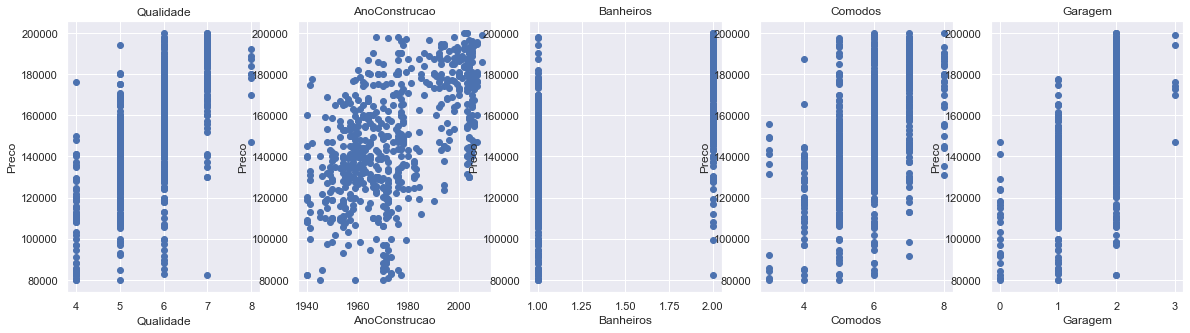

In [8]:
#verifico a dispersão de dados de acordo com as features escolhidas 
features = ['Qualidade', 'AnoConstrucao', 'Banheiros', 'Comodos', 'Garagem']
target = data['Preco']
plt.figure(figsize=(20, 5))

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = data[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Preco')

# Criação do modelo de Machine learning
Para a criação do modelo de machine learning , será utilizado a analise de regressão, onde será aplicado a regressão linear multipla, onde o valor da variavel preço é influenciada por diversas variaveis

In [9]:
#removo as colunas que não serão utilizadas para a criação do modelo
data_features = data.drop(columns=['Id', 'Area', 'Zona', 'QualidadeAquecimento', 'Lareiras', 'Quartos_t1', 'Quartos_t2', 'Preco'])
data_features


,Qualidade,AnoConstrucao,Banheiros,Comodos,Garagem
0,6,1976,2,6,2
1,5,1993,1,5,2
2,5,1965,1,5,1
3,5,1962,1,4,1
4,6,1960,1,5,1
...,...,...,...,...,...
624,6,1966,1,6,1
625,5,1970,1,3,0
626,5,2005,1,5,2
627,6,1999,2,7,2


In [10]:
#divido meu conjunto de dados 
X_train, X_test, Y_train, Y_test = train_test_split(data_features, target, test_size = 0.2, random_state=5)

#crio o modelo
reg = LinearRegression()
reg.fit(X_train, Y_train)
print("O modelo:Vendas = {:.5} + {:.5}*Qualidade+ {:.5}*AnoConstrucao + {:.5}*Banheiros + {:.5}*Comodos + {:.5}*Garagem".format(reg.intercept_, reg.coef_[0], reg.coef_[1], reg.coef_[2], reg.coef_[3], reg.coef_[4]))

O modelo:Vendas = -3.517e+05 + 9049.0*Qualidade+ 192.04*AnoConstrucao + 7414.9*Banheiros + 6839.1*Comodos + 1.2802e+04*Garagem


In [11]:
#verifico o score do modelo passando os dados de teste
reg.score(X_test, Y_test)

0.5807188940088215

In [12]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


y_train_predict = reg.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("Performance do modelo para o conjunto de treino")
print("--------------------------------------")
print('RMSE: {}'.format(rmse))
print('R2 score:  {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = reg.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("Performance do modelo para o conjunto de teste")
print("--------------------------------------")
print('RMSE:  {}'.format(rmse))

Performance do modelo para o conjunto de treino
--------------------------------------
RMSE: 17095.609522828225
R2 score:  0.6325238473878896


Performance do modelo para o conjunto de teste
--------------------------------------
RMSE:  17761.228156392615


In [13]:
#sumario dos  dados estatisticos do modelo
array_features = np.column_stack((X_train['Qualidade'], X_train['AnoConstrucao'], X_train['Banheiros'],X_train['Comodos'], X_train['Garagem']))
X = sm.add_constant(array_features)
est = sm.OLS(Y_train, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     171.1
Date:                Thu, 21 Jan 2021   Prob (F-statistic):          1.37e-105
Time:                        19:52:48   Log-Likelihood:                -5616.3
No. Observations:                 503   AIC:                         1.124e+04
Df Residuals:                     497   BIC:                         1.127e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.517e+05   1.12e+05     -3.139      0.0

In [14]:
#criação do modelo em disco
joblib.dump(reg, 'model')

['model']